In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function_test import *
import pandas as pd
import seaborn as sns
import ast

In [2]:
adjClose1 = pd.read_csv("MIE377_AssetPrices_1.csv", index_col=0)
factorRet1 = pd.read_csv("MIE377_FactorReturns_1.csv", index_col=0)

adjClose2 = pd.read_csv("MIE377_AssetPrices_2.csv", index_col=0)
factorRet2 = pd.read_csv("MIE377_FactorReturns_2.csv", index_col=0)

adjClose3 = pd.read_csv("MIE377_AssetPrices_3.csv", index_col=0)
factorRet3 = pd.read_csv("MIE377_FactorReturns_3.csv", index_col=0)

adj = [adjClose1, adjClose2, adjClose3]
fact = [factorRet1, factorRet2, factorRet3]

# [llambda, L, U, K, L_c, U_c, K_c]

dataset_list = [] 
params_list  = []
sr_list = []
to_list = []
et_list = []

counter = 0

In [4]:
llambda = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
L_c = 0.05
U_c = 0.2
K_c = list(range(10, 16))
L = 0
U = 5
K = 3

all_params = [[sub_llambda, L_c, U_c, sub_K_c, L, U, K] for sub_llambda in llambda for sub_K_c in K_c]
all_params

[[0, 0.05, 0.2, 10, 0, 5, 3],
 [0, 0.05, 0.2, 11, 0, 5, 3],
 [0, 0.05, 0.2, 12, 0, 5, 3],
 [0, 0.05, 0.2, 13, 0, 5, 3],
 [0, 0.05, 0.2, 14, 0, 5, 3],
 [0, 0.05, 0.2, 15, 0, 5, 3],
 [1, 0.05, 0.2, 10, 0, 5, 3],
 [1, 0.05, 0.2, 11, 0, 5, 3],
 [1, 0.05, 0.2, 12, 0, 5, 3],
 [1, 0.05, 0.2, 13, 0, 5, 3],
 [1, 0.05, 0.2, 14, 0, 5, 3],
 [1, 0.05, 0.2, 15, 0, 5, 3],
 [2, 0.05, 0.2, 10, 0, 5, 3],
 [2, 0.05, 0.2, 11, 0, 5, 3],
 [2, 0.05, 0.2, 12, 0, 5, 3],
 [2, 0.05, 0.2, 13, 0, 5, 3],
 [2, 0.05, 0.2, 14, 0, 5, 3],
 [2, 0.05, 0.2, 15, 0, 5, 3],
 [3, 0.05, 0.2, 10, 0, 5, 3],
 [3, 0.05, 0.2, 11, 0, 5, 3],
 [3, 0.05, 0.2, 12, 0, 5, 3],
 [3, 0.05, 0.2, 13, 0, 5, 3],
 [3, 0.05, 0.2, 14, 0, 5, 3],
 [3, 0.05, 0.2, 15, 0, 5, 3],
 [4, 0.05, 0.2, 10, 0, 5, 3],
 [4, 0.05, 0.2, 11, 0, 5, 3],
 [4, 0.05, 0.2, 12, 0, 5, 3],
 [4, 0.05, 0.2, 13, 0, 5, 3],
 [4, 0.05, 0.2, 14, 0, 5, 3],
 [4, 0.05, 0.2, 15, 0, 5, 3],
 [5, 0.05, 0.2, 10, 0, 5, 3],
 [5, 0.05, 0.2, 11, 0, 5, 3],
 [5, 0.05, 0.2, 12, 0, 5, 3],
 [5, 0.05,

In [4]:
for i in range(len(adj)):
    for params in all_params:
        print(params)
        adjClose = adj[i]
        factorRet = fact[i]

        adjClose.index = pd.to_datetime(adjClose.index)
        factorRet.index = pd.to_datetime(factorRet.index)

        # Initial budget to invest ($100,000)
        initialVal = 100000

        # Length of investment period (in months)
        investPeriod = 6

        # divide the factor returns by  100
        factorRet = factorRet/100

        #rf and factor returns
        riskFree = factorRet['RF']
        factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

        #Identify the tickers and the dates
        tickers = adjClose.columns
        dates   = factorRet.index

        # Calculate the stocks monthly excess returns
        # pct change and drop the first null observation
        returns = adjClose.pct_change(1).iloc[1:, :]
        returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
        # Align the price table to the asset and factor returns tables by discarding the first observation.
        adjClose = adjClose.iloc[1:,:]

        assert adjClose.index[0] == returns.index[0]
        assert adjClose.index[0] == factorRet.index[0]

        # Start of out-of-sample test period
        testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

        #End of the first investment period
        testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

        # End of calibration period
        calEnd = testStart -  pd.offsets.DateOffset(days = 1)

        # Total number of investment periods
        NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

        # Number of assets
        n  = len(tickers)

        # Preallocate space for the portfolio weights (x0 will be used to calculate
        # the turnover rate)
        x  = np.zeros([n, NoPeriods])
        x0 = np.zeros([n, NoPeriods])

        # Preallocate space for the portfolio per period value and turnover
        currentVal = np.zeros([NoPeriods, 1])
        turnover   = np.zeros([NoPeriods, 1])

        #Initiate counter for the number of observations per investment period
        toDay = 0

        # Measure runtime: start the clock
        start_time = time.time()

        # Empty list to measure the value of the portfolio over the period
        portfValue = []

        for t in range(NoPeriods):
            # Subset the returns and factor returns corresponding to the current calibration period.
            periodReturns = returns[returns.index <= calEnd]
            periodFactRet = factorRet[factorRet.index <= calEnd]

            current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
            currentPrices = adjClose[current_price_idx]

            # Subset the prices corresponding to the current out-of-sample test period.
            periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
            periodPrices = adjClose[periodPrices_idx]

            assert len(periodPrices) == investPeriod
            assert len(currentPrices) == 1
            # Set the initial value of the portfolio or update the portfolio value
            if t == 0:
                currentVal[0] = initialVal
            else:
                currentVal[t] = currentPrices @  NoShares.values.T
                #Store the current asset weights (before optimization takes place)
                x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

            #----------------------------------------------------------------------
            # Portfolio optimization
            # You must write code your own algorithmic trading function
            # The project function is in the services folder
            # Take in the period returns and period factor returns and produce
            # an allocation
            #----------------------------------------------------------------------
            x[:,t] = project_function_test(periodReturns, periodFactRet, x0[:,t], params)

            #Calculate the turnover rate
            if t > 0:
                turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

            # Number of shares your portfolio holds per stock
            NoShares = x[:,t]*currentVal[t]/currentPrices

            # Update counter for the number of observations per investment period
            fromDay = toDay
            toDay   = toDay + len(periodPrices)

            # Weekly portfolio value during the out-of-sample window
            portfValue.append(periodPrices@ NoShares.values.T)

            # Update your calibration and out-of-sample test periods
            testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
            testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
            calEnd    = testStart - pd.offsets.DateOffset(days=1)

        portfValue = pd.concat(portfValue, axis = 0)
        end_time = time.time()

        #--------------------------------------------------------------------------
        # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
        #-----------------------------------------------------------------------
        # Calculate the observed portfolio returns
        portfRets = portfValue.pct_change(1).iloc[1:,:]

        # Calculate the portfolio excess returns
        portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

        # Calculate the portfolio Sharpe ratio
        SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

        # Calculate the average turnover rate
        avgTurnover = np.mean(turnover[1:])

        dataset_list.append(i+1)
        params_list.append(params)
        sr_list.append(SR[0])
        to_list.append(avgTurnover)
        et_list.append(end_time - start_time)

        counter += 1
        print('Iteration {} done\n'.format(counter))

[0, 0.05, 0.2, 10, 0, 5, 3]
Restricted license - for non-production use only - expires 2025-11-24


Iteration 1 done

[0, 0.05, 0.2, 11, 0, 5, 3]
Iteration 2 done

[0, 0.05, 0.2, 12, 0, 5, 3]
Iteration 3 done

[0, 0.05, 0.2, 13, 0, 5, 3]
Iteration 4 done

[0, 0.05, 0.2, 14, 0, 5, 3]
Iteration 5 done

[0, 0.05, 0.2, 15, 0, 5, 3]
Iteration 6 done

[1, 0.05, 0.2, 10, 0, 5, 3]
Iteration 7 done

[1, 0.05, 0.2, 11, 0, 5, 3]
Iteration 8 done

[1, 0.05, 0.2, 12, 0, 5, 3]
Iteration 9 done

[1, 0.05, 0.2, 13, 0, 5, 3]
Iteration 10 done

[1, 0.05, 0.2, 14, 0, 5, 3]
Iteration 11 done

[1, 0.05, 0.2, 15, 0, 5, 3]
Iteration 12 done

[2, 0.05, 0.2, 10, 0, 5, 3]
Iteration 13 done

[2, 0.05, 0.2, 11, 0, 5, 3]
Iteration 14 done

[2, 0.05, 0.2, 12, 0, 5, 3]
Iteration 15 done

[2, 0.05, 0.2, 13, 0, 5, 3]
Iteration 16 done

[2, 0.05, 0.2, 14, 0, 5, 3]
Iteration 17 done

[2, 0.05, 0.2, 15, 0, 5, 3]
Iteration 18 done

[3, 0.05, 0.2, 10, 0, 5, 3]
Iteration 19 done

[3, 0.05, 0.2, 11, 0, 5, 3]
Iteration 20 done

[3, 0.05, 0.2, 12, 0, 5, 3]
Iteration 21 done

[3, 0.05, 0.2, 13, 0, 5, 3]
Iteration 22 done

[3,

In [5]:
df = pd.DataFrame({'Dataset': dataset_list, 
                   'Parameters': params_list, 
                   'Sharpe Ratio': sr_list, 
                   'Average Turnover': to_list, 
                   'Elapsed Time': et_list})

df.to_csv('results1.csv')

In [6]:
df = pd.read_csv('results1.csv')
df = df.drop('Unnamed: 0', axis=1)
df['Parameters'] = df['Parameters'].apply(ast.literal_eval)

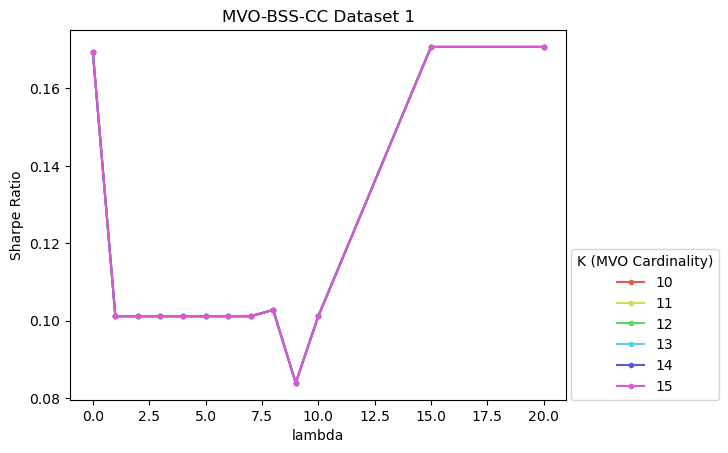

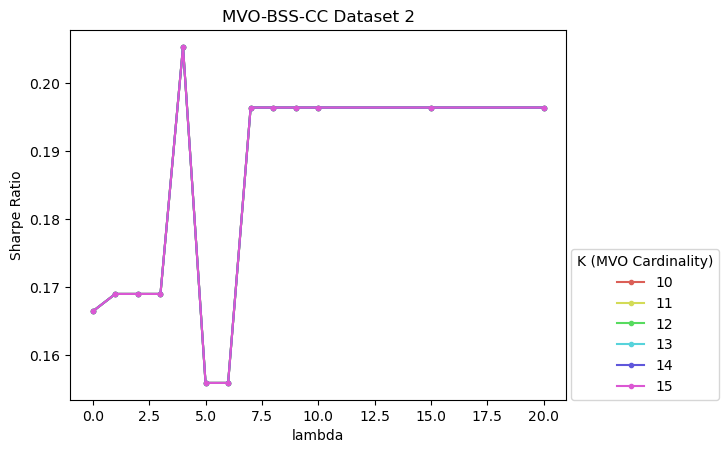

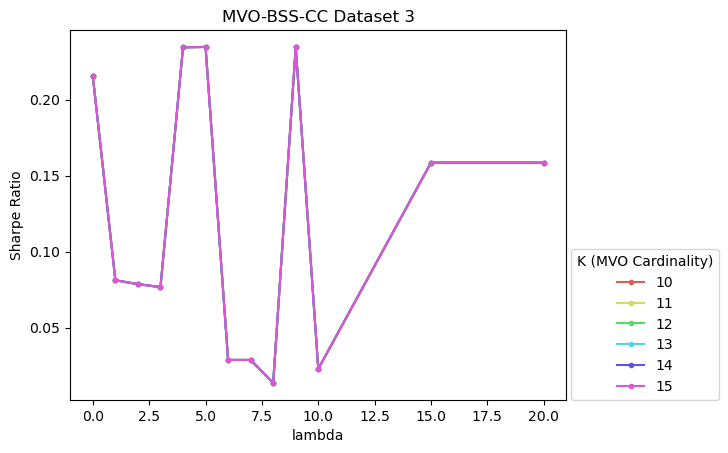

In [19]:
clrs = sns.color_palette('hls', n_colors=len(K_c))

for i in range(1, 4):
    j = 0
    for kc in K_c:
        sub_df = df[(df['Dataset'] == i) & (df['Parameters'].apply(lambda x: x[3]) == kc)]
        plt.plot(sub_df['Parameters'].apply(lambda x: x[0]), sub_df['Sharpe Ratio'], '.-', color=clrs[j], label=kc)
        j += 1

    plt.legend(title='K (MVO Cardinality)', loc=(1.01, 0))
    plt.title('MVO-BSS-CC Dataset {}'.format(i))
    plt.xlabel('lambda')
    plt.ylabel('Sharpe Ratio')

    plt.show()

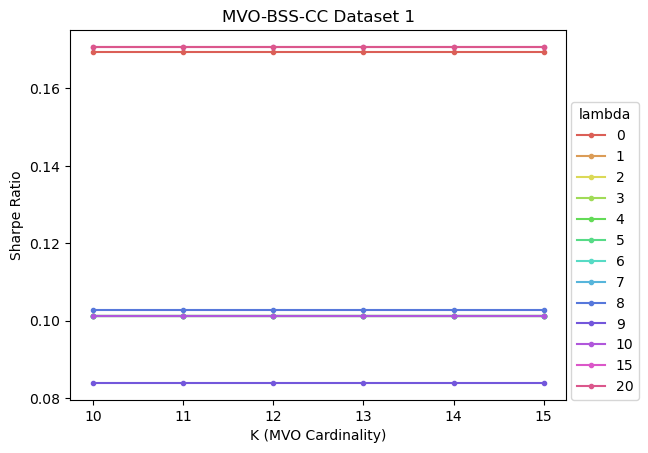

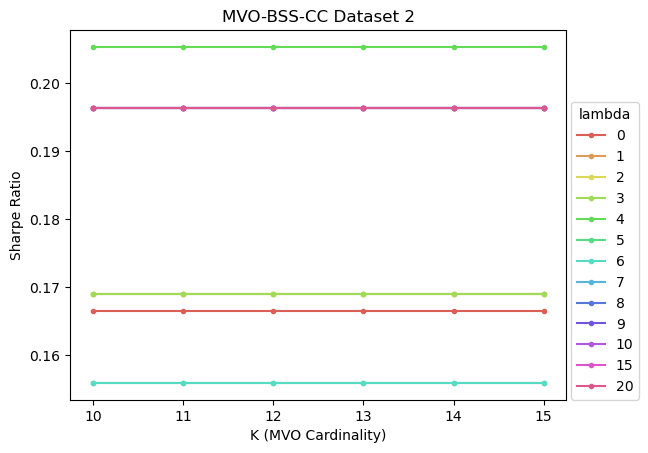

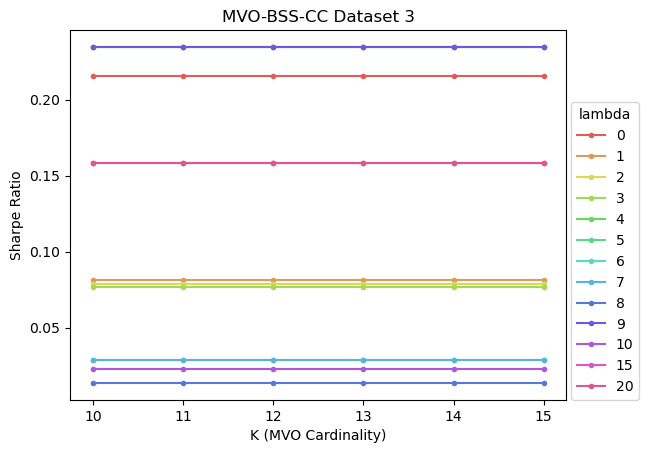

In [20]:
clrs = sns.color_palette('hls', n_colors=len(llambda))

for i in range(1, 4):
    j = 0
    for l in llambda:
        sub_df = df[(df['Dataset'] == i) & (df['Parameters'].apply(lambda x: x[0]) == l)]
        plt.plot(sub_df['Parameters'].apply(lambda x: x[3]), sub_df['Sharpe Ratio'], '.-', color=clrs[j], label=l)
        j += 1

    plt.legend(title='lambda', loc=(1.01, 0))
    plt.title('MVO-BSS-CC Dataset {}'.format(i))
    plt.xlabel('K (MVO Cardinality)')
    plt.ylabel('Sharpe Ratio')

    plt.show()

<Figure size 640x480 with 0 Axes>

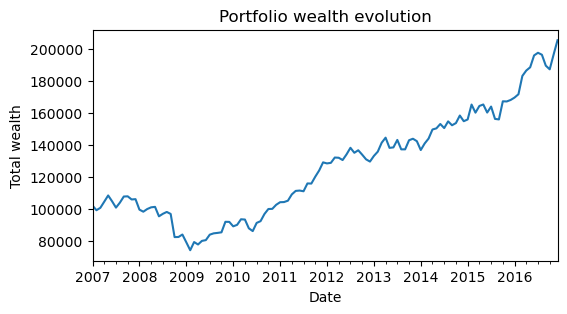

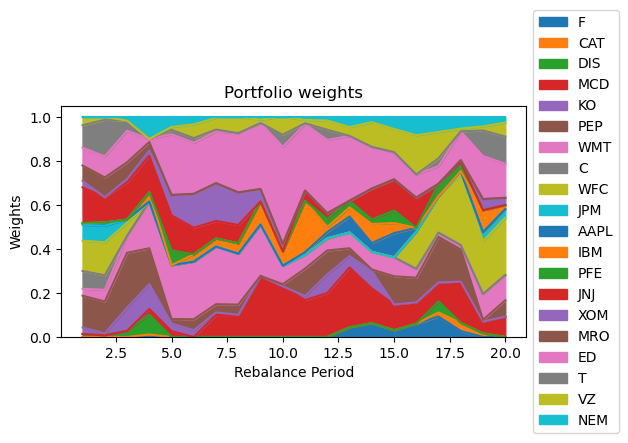

In [9]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End